# Importing libraries and tools

In [6]:
# Import necessary libraries for data manipulation and analysis
import numpy as np  # NumPy for numerical operations and array handling
import pandas as pd  # Pandas for data manipulation and analysis

# Import OS module for file path manipulation
import os  # To handle file paths and directory operations

# Import visualization libraries
import matplotlib.pyplot as plt  # Matplotlib for creating static, animated, and interactive visualizations
import seaborn as sns  # Seaborn for statistical data visualization, built on top of Matplotlib
from scipy import stats  # SciPy for scientific and technical computing, including statistical functions

# Import functions for model selection and evaluation
from sklearn.model_selection import train_test_split  # For splitting datasets into training and testing sets
from sklearn.model_selection import cross_val_score  # For performing cross-validation on models

# Import regression models
from sklearn.ensemble import RandomForestRegressor  # Random Forest model for regression tasks
from sklearn.ensemble import AdaBoostRegressor  # AdaBoost model for boosting weak learners
import lightgbm as lgb  # LightGBM for gradient boosting on decision trees
import xgboost as xgb  # XGBoost for extreme gradient boosting

# Import base classes for custom transformers and estimators
from sklearn.base import BaseEstimator, TransformerMixin  # Base classes for building custom estimators

# Import metrics for model evaluation
from sklearn.metrics import mean_squared_error  # For calculating mean squared error (MSE) of predictions

# Import ensemble methods for combining multiple models
from sklearn.ensemble import VotingRegressor  # For combining multiple regression models

# Import feature selection methods
from sklearn.feature_selection import SelectKBest, f_regression  # For selecting the best features based on regression tests

# Import preprocessing utilities
from sklearn.preprocessing import StandardScaler  # For standardizing features by removing the mean and scaling to unit variance

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
dirname = '/kaggle/input/house-prices-advanced-regression-techniques/'
# using os.path.join to ensure that the code works correctly on different operating systems.
# they have different conventions for representing file paths.
train = pd.read_csv(os.path.join(dirname, "train.csv"), index_col = "Id") # index_col to specify which column should be used as the row labels (index) for the DataFrame
test = pd.read_csv(os.path.join(dirname, "test.csv"), index_col = "Id")

# 1. Exploratory Data Analysis (EDA)

## a. Checking for duplicates

In [8]:
# check for duplicates between test and train
print(f"train duplicates = {len(train[train.duplicated()])} rows")
print(f"test duplicates = {len(test[test.duplicated()])} rows")
print(f"train in test duplicates = {len(train[train.isin(test).all(axis=1)])} rows")

train duplicates = 0 rows
test duplicates = 0 rows
train in test duplicates = 0 rows


## b. Visualizing nulls

In [9]:
def get_NA_info(feature_columns: list):
    """
    Displays the number of missing values (NAs) for specified features 
    in both training and testing datasets.

    Parameters:
    feature_columns (list): A list of feature names (columns) to check for missing values.

    Returns:
    None: This function prints the missing value information directly.
    """
    sorted_features = []  # Initialize a list to hold feature NA information

    # Iterate over each feature in the provided list
    for feat in feature_columns:
        # Count the number of NAs in the training set for the feature
        train_NAs = train[feat].isna().sum()
        train_total = train.shape[0]  # Get the total number of rows in the training set

        # Count the number of NAs in the testing set for the feature
        test_NAs = test[feat].isna().sum()
        test_total = test.shape[0]  # Get the total number of rows in the testing set
        
        # Append a tuple containing the feature name, NA counts, and total counts
        sorted_features.append((feat, train_NAs, train_total, test_NAs, test_total))

    # Sort the features based on the number of NAs in descending order
    sorted_features.sort(reverse=True, key=lambda x: (x[1], x[3]))

    # Print the header for the missing values summary
    print(f"{'Feature':13s} {'Train NA/Total'} | {'Test NA/Total'}")
    print("----------------------------------------")

    # Iterate through the sorted features and print the missing values information
    for feat, train_na, train_total, test_na, test_total in sorted_features:
        print(f"{feat:18s} {train_na:4d}/{train_total:4d} | {test_na:4d}/{test_total:4d}")

In [ ]:
# print object feature nulls
object_features = [feat for feat in train.columns if train[feat].dtype == "O"]

get_NA_info(object_features)

In [ ]:
# print numeric feature nulls
numeric_features = [feat for feat in train.columns if feat not in {"Id", "SalePrice"} and train[feat].dtype != "O"]

get_NA_info(numeric_features)

## c. Visualizing numeric features

In [10]:
def plot_all_numeric_features():
    # pick out the valied continuous features to take a look at the distributions
    continuous_numeric_features = [feat for feat in train.columns if feat not in {'Id'} and train[feat].dtype != "O"]

    for feat in continuous_numeric_features:
        print(feat) # to faster identify the plot using Ctrl + F
        fig, axes = plt.subplots(ncols=5, figsize=(20, 4))

        sns.histplot(train[feat], kde=True, ax=axes[0]) # plotting the feature distribution
        stats.probplot(train[feat], plot=axes[1]) # QQ plot to know how close it is to the normal

        # applying log1p (log(1+x)). It is a common function to apply to
        # skewed distributions (towards left, right, big or small values)
        #  Skewed distributions can result in a few extremely high or low 
        # values influencing the model's predictions disproportionately, leading to poor generalization.
        # the log1p transformation tends to have a more significant impact on reducing the influence of 
        # larger values compared to smaller values. This is due to the nature of the logarithmic function.
        # it "pulls in" the larger values closer to the smaller values
        # On the other hand, smaller values are affected less
        # E.x the logarithm of values close to 1 is still very close to 0.
        sns.histplot(np.log1p(train[feat]), kde=True, ax=axes[2])
        stats.probplot(np.log1p(train[feat]), plot=axes[3])

        # scatter point to look at outliers and handle them visually as well
        sns.scatterplot(x=train[feat], y=train["SalePrice"], ax=axes[4])

        axes[0].set_title(f'{feat} distribution')
        axes[1].set_title(f'{feat} QQ plot')
        axes[2].set_title(f'log(1+x) {feat} distribution')
        axes[3].set_title(f'log(1+x) {feat} QQ plot')
        axes[4].set_title(f'{feat} visual outliers')

        plt.show()

In [ ]:
plot_all_numeric_features()

# 2. Data preprocessing

## a. Dealing with outliers
### We have 3 different function to try for the models.

### 1. Strict - has the highest biases and drop the most points
### 2. Moderate - medium biases and drop less points
### 3. Light - drops the least amount of points

In [11]:
def handle_outliers_strict(df_data):
    """
    Removes strict outliers from the provided DataFrame based on predefined thresholds.

    Parameters:
    df_data (DataFrame): The input DataFrame containing housing data.

    Returns:
    DataFrame: A copy of the DataFrame with outliers removed.
    """
    df_copy = df_data.copy()  # Create a copy of the DataFrame to avoid modifying the original

    # Identify outliers based on strict criteria for various features
    outliers_indexes = set(
        df_copy[df_copy["SalePrice"] > 700_000].index.tolist() +
        df_copy[df_copy["LotFrontage"] > 300].index.tolist() +
        df_copy[df_copy["LotArea"] > 100_000].index.tolist() +
        df_copy[df_copy["MasVnrArea"] > 1250].index.tolist() +
        df_copy[df_copy["TotalBsmtSF"] > 5000].index.tolist() +
        df_copy[df_copy["1stFlrSF"] > 5000].index.tolist() +
        df_copy[df_copy["2ndFlrSF"] > 2000].index.tolist() +
        df_copy[df_copy["GrLivArea"] > 4000].index.tolist() +
        df_copy[df_copy["WoodDeckSF"] > 800].index.tolist() +
        df_copy[df_copy["OpenPorchSF"] > 420].index.tolist() +
        df_copy[df_copy["EnclosedPorch"] > 400].index.tolist() +
        df_copy[df_copy["3SsnPorch"] > 400].index.tolist() +
        df_copy[df_copy["PoolArea"] > 550].index.tolist() +
        df_copy[df_copy["BsmtFinSF1"] > 4000].index.tolist() +
        df_copy[df_copy["BsmtFinSF2"] > 1400].index.tolist()
    )

    df_copy.drop(outliers_indexes, axis=0, inplace=True)  # Drop outliers from the DataFrame
    print(f"Removed {len(outliers_indexes)} outliers")  # Print the number of outliers removed
    
    return df_copy  # Return the modified DataFrame


def handle_outliers_moderate(df_data):
    """
    Removes moderate outliers from the provided DataFrame based on predefined thresholds.

    Parameters:
    df_data (DataFrame): The input DataFrame containing housing data.

    Returns:
    DataFrame: A copy of the DataFrame with outliers removed.
    """
    df_copy = df_data.copy()  # Create a copy of the DataFrame to avoid modifying the original

    # Identify outliers based on moderate criteria for various features
    outliers_indexes = set(
        df_copy[df_copy["SalePrice"] > 700_000].index.tolist() +
        df_copy[df_copy["LotFrontage"] > 300].index.tolist() +
        df_copy[df_copy["LotArea"] > 140_000].index.tolist() +
        df_copy[df_copy["MasVnrArea"] > 1300].index.tolist() +
        df_copy[df_copy["TotalBsmtSF"] > 5000].index.tolist() +
        df_copy[df_copy["1stFlrSF"] > 5000].index.tolist() +
        df_copy[df_copy["2ndFlrSF"] > 2000].index.tolist() +
        df_copy[df_copy["GrLivArea"] > 4000].index.tolist() +
        df_copy[df_copy["WoodDeckSF"] > 800].index.tolist() +
        df_copy[df_copy["OpenPorchSF"] > 450].index.tolist() +
        df_copy[df_copy["EnclosedPorch"] > 400].index.tolist() +
        df_copy[df_copy["3SsnPorch"] > 400].index.tolist() +
        df_copy[df_copy["PoolArea"] > 600].index.tolist() +
        df_copy[df_copy["BsmtFinSF1"] > 4000].index.tolist() +
        df_copy[df_copy["BsmtFinSF2"] > 1400].index.tolist()
    )

    df_copy.drop(outliers_indexes, axis=0, inplace=True)  # Drop outliers from the DataFrame
    print(f"Removed {len(outliers_indexes)} outliers")  # Print the number of outliers removed
    
    return df_copy  # Return the modified DataFrame


def handle_outliers_light(df_data):
    """
    Removes light outliers from the provided DataFrame based on predefined thresholds.

    Parameters:
    df_data (DataFrame): The input DataFrame containing housing data.

    Returns:
    DataFrame: A copy of the DataFrame with outliers removed.
    """
    df_copy = df_data.copy()  # Create a copy of the DataFrame to avoid modifying the original

    # Identify outliers based on light criteria for various features
    outliers_indexes = set(
        df_copy[df_copy["SalePrice"] > 700_000].index.tolist() +
        df_copy[df_copy["LotFrontage"] > 300].index.tolist() +
        df_copy[df_copy["LotArea"] > 200_000].index.tolist() +
        df_copy[df_copy["MasVnrArea"] > 1500].index.tolist() +
        df_copy[df_copy["TotalBsmtSF"] > 5000].index.tolist() +
        df_copy[df_copy["1stFlrSF"] > 5000].index.tolist() +
        df_copy[df_copy["2ndFlrSF"] > 2000].index.tolist() +
        df_copy[df_copy["GrLivArea"] > 5000].index.tolist() +
        df_copy[df_copy["WoodDeckSF"] > 800].index.tolist() +
        df_copy[df_copy["OpenPorchSF"] > 500].index.tolist() +
        df_copy[df_copy["EnclosedPorch"] > 400].index.tolist() +
        df_copy[df_copy["3SsnPorch"] > 500].index.tolist() +
        df_copy[df_copy["PoolArea"] > 650].index.tolist() +
        df_copy[df_copy["BsmtFinSF1"] > 4000].index.tolist() +
        df_copy[df_copy["BsmtFinSF2"] > 1400].index.tolist()
    )

    df_copy.drop(outliers_indexes, axis=0, inplace=True)  # Drop outliers from the DataFrame
    print(f"Removed {len(outliers_indexes)} outliers")  # Print the number of outliers removed
    
    return df_copy  # Return the modified DataFrame


## b. Dealing with missing values

In [12]:
def deal_with_missing_values(df_train, df_test):
    _train = df_train.copy()
    _test = df_test.copy()

    # Drop columns with too many missing values
    columns_to_drop = ['PoolQC', 'MiscFeature', 'Alley']
    _train.drop(columns=columns_to_drop, axis=1, inplace=True)
    _test.drop(columns=columns_to_drop, axis=1, inplace=True)

    # Fill missing values for specific columns with 'NA'
    fill_na_columns = {
        'Fence': 'NA',
        'FireplaceQu': 'NA',
    }
    
    for col, value in fill_na_columns.items():
        _train[col].fillna(value, inplace=True)
        _test[col].fillna(value, inplace=True)

    # Handle garages
    garage_cols = ['GarageFinish', 'GarageQual', 'GarageCond', 'GarageType']
    no_garages_train = _train[garage_cols].isna().all(axis=1)
    no_garages_test = _test[garage_cols].isna().all(axis=1)

    for col in garage_cols:
        _train.loc[no_garages_train, col] = 'NA'
        _train.loc[no_garages_train, 'GarageYrBlt'] = 0.0

        _test.loc[no_garages_test, col] = 'NA'
        _test.loc[no_garages_test, 'GarageYrBlt'] = 0.0

    # Fill remaining garage values
    garage_defaults = {
        'GarageYrBlt': 1933,
        'GarageFinish': 'Unf',
        'GarageCars': 1.0,
        'GarageArea': 231.0,
        'GarageQual': 'TA',
        'GarageCond': 'TA'
    }
    
    for col, value in garage_defaults.items():
        _test[col].fillna(value, inplace=True)

    # Handle basement missing values similarly
    basement_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
    no_bsmt_train = _train[basement_cols].isna().all(axis=1)
    no_bsmt_test = _test[basement_cols].isna().all(axis=1)

    for col in basement_cols:
        _train.loc[no_bsmt_train, col] = 'NA'
        _test.loc[no_bsmt_test, col] = 'NA'

    # Fill other basement missing values
    basement_defaults = {
        'BsmtExposure': 'No',
        'BsmtQual': 'Gd',
        'BsmtCond': 'TA',
        'BsmtFinSF1': 0.0,
        'BsmtFinSF2': 0.0,
        'BsmtUnfSF': 0.0,
        'TotalBsmtSF': 0.0
    }

    for col, value in basement_defaults.items():
        _train[col].fillna(value, inplace=True)
        _test[col].fillna(value, inplace=True)

    # Handle masonry and other categorical columns
    categorical_fills = {
        'MasVnrType': 'None',
        'Electrical': 'SBrkr',
        'MSZoning': 'RL',
        'Utilities': 'AllPub',
        'Functional': 'Typ',
        'Exterior1st': 'VinylSd',
        'Exterior2nd': 'VinylSd',
        'KitchenQual': 'TA',
        'SaleType': 'WD'
    }
    
    for col, value in categorical_fills.items():
        _train[col].fillna(value, inplace=True)
        _test[col].fillna(value, inplace=True)

    # Handle LotFrontage and MasVnrArea with median and specific logic
    _train['LotFrontage'].fillna(_train['LotFrontage'].median(), inplace=True)
    _test['LotFrontage'].fillna(_test['LotFrontage'].median(), inplace=True)

    mas_vnr_nulls_train = _train['MasVnrArea'].isna()
    mas_vnr_nulls_test = _test['MasVnrArea'].isna()
    
    _train.loc[mas_vnr_nulls_train, 'MasVnrArea'] = 0
    _test.loc[mas_vnr_nulls_test, 'MasVnrArea'] = 0

    # Verify that there are no remaining nulls
    print("Handling nulls is done. Check for nulls...")
    print(f"Does train have nulls? {_train.isnull().any().any()}")
    print(f"Does test have nulls? {_test.isnull().any().any()}")

    return _train, _test

## c. Dealing with categoricals

In [13]:
# Function to handle ordinal categories (which have a meaningful order)
def ordinal_encode_column(dictionary_values, column, data_frames):
    # Loop through each dataframe provided in the list
    for data_frame in data_frames:
        # Apply the mapping from dictionary_values to the specified column
        data_frame[column] = data_frame[column].apply(
            lambda x: dictionary_values[x] if x in dictionary_values else x
        )

def handle_categoricals(train_df, test_df):
    # Create copies of the train and test DataFrames to avoid modifying the originals
    _train = train_df.copy()
    _test = test_df.copy()
    _dfs = [_train, _test]  # List to hold both DataFrames for processing
    
    # ---- Dealing with ordinals ----
    # List of columns that contain ordinal categorical data
    _ordinals = ['LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 'HeatingQC', 
                 'KitchenQual', 'BsmtQual', 'BsmtCond', 'FireplaceQu', 
                 'GarageQual', 'GarageCond', 'BsmtExposure', 'CentralAir', 
                 'GarageFinish', 'PavedDrive', 'Utilities']

    # Define mappings for ordinal columns and encode them
    _impute_dict = {'Reg': 0, 'IR1': 1, 'IR2': 2, 'IR3': 3}
    ordinal_encode_column(_impute_dict, 'LotShape', _dfs)
    
    _impute_dict = {'Gtl': 1, 'Mod': 2, 'Sev': 3}
    ordinal_encode_column(_impute_dict, 'LandSlope', _dfs)
    
    # Encoding for quality indicators with a higher number indicating better quality
    _impute_dict = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'MISSING': 0}
    ordinal_encode_column(_impute_dict, 'ExterQual', _dfs)
    ordinal_encode_column(_impute_dict, 'ExterCond', _dfs)
    ordinal_encode_column(_impute_dict, 'HeatingQC', _dfs)
    ordinal_encode_column(_impute_dict, 'KitchenQual', _dfs)
    
    # Handling basement quality with special cases for missing values
    _impute_dict = {'MISSING': 0, 'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 
                    "NA": 1, 'NO_BASEMENT': 1, 'NO_GARAGE': 1}
    ordinal_encode_column(_impute_dict, 'BsmtQual', _dfs)
    ordinal_encode_column(_impute_dict, 'BsmtCond', _dfs)
    ordinal_encode_column(_impute_dict, 'FireplaceQu', _dfs)
    ordinal_encode_column(_impute_dict, 'GarageQual', _dfs)
    ordinal_encode_column(_impute_dict, 'GarageCond', _dfs)
    
    # Encoding for basement exposure with missing values handled
    _impute_dict = {'NO': 0, 'No': 2, 'Mn': 3, 'Av': 4, 'Gd': 5, 'NA': 1}
    ordinal_encode_column(_impute_dict, 'BsmtExposure', _dfs)
    
    # Encoding for central air conditioning
    _impute_dict = {'Y': 1, 'N': 0}
    ordinal_encode_column(_impute_dict, 'CentralAir', _dfs)
    
    # Encoding for garage finish
    _impute_dict = {'MISSING': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3, 'NA': 1}
    ordinal_encode_column(_impute_dict, 'GarageFinish', _dfs)
    
    # Encoding for paved driveways
    _impute_dict = {'Y': 2, 'P': 1, 'N': 0}
    ordinal_encode_column(_impute_dict, 'PavedDrive', _dfs)
    
    # Encoding for utilities with a higher number indicating better services
    _impute_dict = {'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1, 'MISSING': 0}
    ordinal_encode_column(_impute_dict, 'Utilities', _dfs)

    # ---- Dealing with nominals ----
    # List of columns that contain nominal categorical data
    nominals = ['MSZoning', 'Street', 'LandContour', 'LotConfig', 'Neighborhood', 
                'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 
                'MasVnrType', 'Foundation', 'Heating', 'Electrical', 
                'Functional', 'GarageType', 'SaleType', 'SaleCondition', 
                'MSSubClass', 'Condition1', 'Condition2', 'Exterior1st', 
                'Exterior2nd', 'BsmtFinType1', 'BsmtFinType2', 'Fence']

    # Create one-hot encoded columns for nominal variables
    train_dummies = pd.get_dummies(_train[nominals], columns=nominals).astype(int)
    _train = pd.concat([_train, train_dummies], axis=1)  # Add new dummy columns
    _train.drop(nominals, axis=1, inplace=True)  # Drop original nominal columns
    
    test_dummies = pd.get_dummies(_test[nominals], columns=nominals).astype(int)
    _test = pd.concat([_test, test_dummies], axis=1)  # Add new dummy columns
    _test.drop(nominals, axis=1, inplace=True)  # Drop original nominal columns
    
    # It is not crucial for tree algorithms to maintain the same amount of columns,
    # but advanced ones such as LightGBM and XGBoost require equality in feature sets
    absent_in_test = set(_train.columns) - set(_test.columns)  # Columns in train not in test
    absent_in_train = set(_test.columns) - set(_train.columns)  # Columns in test not in train
    
    # Fill missing columns in test with zeroes
    if len(absent_in_test) > 0:
        for col in absent_in_test:
            if col != "SalePrice":  # Ensure SalePrice is not added in test
                _test[col] = 0  # Fill with 0 for absent columns
                
    # Fill missing columns in train with zeroes
    if len(absent_in_train) > 0:
        for col in absent_in_train:
            _train[col] = 0  # Fill with 0 for absent columns
                
    # Sort the columns to ensure they are in the same order
    _sorted_columns_train = sorted(_train.columns)
    _sorted_columns_test = sorted(_test.columns)
    
    _train = _train[_sorted_columns_train]  # Reorder train DataFrame
    _test = _test[_sorted_columns_test]      # Reorder test DataFrame
    
    # Print the shapes of the transformed DataFrames
    print(f"Train shape: {_train.shape}")
    print(f"Test shape: {_test.shape}")
    
    # Check if the columns in train and test are equal (excluding the target variable)
    print("Are train and test columns equal?", (_train.columns.drop('SalePrice')).equals(_test.columns))
    
    return _train, _test  # Return the processed train and test DataFrames


# 3. Feature Engineering

In [14]:
def apply_feature_engineering(dataframe_train, dataframe_test, 
                              addisFence=True, addisFireplace=True, 
                              apply_add_HouseAge=True, apply_add_isRemodelled=True, 
                              apply_add_RemodelledYearsAgo=True, 
                              apply_add_BsmtFinSF_remove_SF1_SF2=True, 
                              addisMasonry=True, addisSecondFloor=True, 
                              addisFullBathBsmtDropBsmtHalfBath=True, 
                              addisBsmtHalfBathDropBsmtHalfBath=True, 
                              addisFullBathDropFullBath=True, 
                              addisHalfBathDropHalfBath=True, 
                              addisFireplaceDropFireplaces=True, 
                              addisWoodDeck=True, 
                              addisOpenPorch=True, 
                              addisGarage=True, 
                              addisBasement=True, 
                              addTotalBsmtSFComb=True, 
                              addOverallQualComb=True):
    """
    Apply feature engineering techniques to enhance the training and testing dataframes for a housing dataset.
    
    Parameters:
    dataframe_train (DataFrame): The training dataframe containing house features and target variable.
    dataframe_test (DataFrame): The testing dataframe containing house features.
    addisFence (bool): If True, adds a binary feature indicating the presence of a fence.
    addisFireplace (bool): If True, adds a binary feature indicating the presence of a fireplace.
    apply_add_HouseAge (bool): If True, calculates the age of the house at the time of sale.
    apply_add_isRemodelled (bool): If True, adds a binary feature indicating if the house has been remodeled.
    apply_add_RemodelledYearsAgo (bool): If True, calculates the years since the house was remodeled.
    apply_add_BsmtFinSF_remove_SF1_SF2 (bool): If True, combines basement finished square footage and removes individual features.
    addisMasonry (bool): If True, adds a binary feature indicating the presence of masonry.
    addisSecondFloor (bool): If True, adds a binary feature indicating the presence of a second floor.
    addisFullBathBsmtDropBsmtHalfBath (bool): If True, indicates if there is a full bath in the basement and drops the original feature.
    addisBsmtHalfBathDropBsmtHalfBath (bool): If True, indicates if there is a half bath in the basement and drops the original feature.
    addisFullBathDropFullBath (bool): If True, indicates if there is a full bath and drops the original feature.
    addisHalfBathDropHalfBath (bool): If True, indicates if there is a half bath and drops the original feature.
    addisFireplaceDropFireplaces (bool): If True, indicates if there is at least one fireplace and drops the original feature.
    addisWoodDeck (bool): If True, adds a binary feature indicating the presence of a wood deck.
    addisOpenPorch (bool): If True, adds a binary feature indicating the presence of an open porch.
    addisGarage (bool): If True, adds a binary feature indicating the presence of a garage.
    addisBasement (bool): If True, adds a binary feature indicating the presence of a basement.
    addTotalBsmtSFComb (bool): If True, creates a combined feature for total basement square footage multiplied by first floor square footage.
    addOverallQualComb (bool): If True, creates a combined feature for overall quality and overall condition.
    
    Returns:
    DataFrame, DataFrame: The modified training and testing dataframes with the applied feature engineering techniques.
    """
    
    # Create copies of the input dataframes to avoid modifying the original data
    df_train_copy = dataframe_train.copy()
    df_test_copy = dataframe_test.copy()

    # Add a binary feature indicating the presence of a fence
    if addisFence:
        df_train_copy['isFence'] = df_train_copy['Fence'].apply(lambda x: 0 if pd.isna(x) else 1)
        df_test_copy['isFence'] = df_test_copy['Fence'].apply(lambda x: 0 if pd.isna(x) else 1)
    
    # Add a binary feature indicating the presence of a fireplace
    if addisFireplace:
        df_train_copy['isFireplace'] = df_train_copy['FireplaceQu'].apply(lambda x: 0 if pd.isna(x) else 1)
        df_test_copy['isFireplace'] = df_test_copy['FireplaceQu'].apply(lambda x: 0 if pd.isna(x) else 1)

    # Calculate and add the age of the house at the time of sale
    if apply_add_HouseAge:
        df_train_copy['HouseAge'] = df_train_copy['YrSold'] - df_train_copy['YearBuilt']
        df_test_copy['HouseAge'] = df_test_copy['YrSold'] - df_test_copy['YearBuilt']
    
    # Add a binary feature indicating if the house has been remodeled
    if apply_add_isRemodelled:
        df_train_copy['isRemodelled'] = df_train_copy.apply(lambda x: 0 if x['YearRemodAdd'] == x['YearBuilt'] else 1, axis=1)
        df_test_copy['isRemodelled'] = df_test_copy.apply(lambda x: 0 if x['YearRemodAdd'] == x['YearBuilt'] else 1, axis=1)

    # Calculate the years since the house was remodeled
    if apply_add_RemodelledYearsAgo:
        df_train_copy['RemodelledYearsAgo'] = df_train_copy['YearRemodAdd'] - df_train_copy['YearBuilt']
        df_test_copy['RemodelledYearsAgo'] = df_test_copy['YearRemodAdd'] - df_test_copy['YearBuilt']
    
    # Combine basement finished square footage and drop individual features
    if apply_add_BsmtFinSF_remove_SF1_SF2:
        df_train_copy['BsmtFinSF'] = df_train_copy['BsmtFinSF1'] + df_train_copy['BsmtFinSF2']
        df_train_copy.drop(['BsmtFinSF1', 'BsmtFinSF2'], axis=1, inplace=True)

        df_test_copy['BsmtFinSF'] = df_test_copy['BsmtFinSF1'] + df_test_copy['BsmtFinSF2']
        df_test_copy.drop(['BsmtFinSF1', 'BsmtFinSF2'], axis=1, inplace=True)

    # Add a binary feature indicating the presence of masonry
    if addisMasonry:
        df_train_copy['isMasonry'] = df_train_copy['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)
        df_test_copy['isMasonry'] = df_test_copy['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)

    # Add a binary feature indicating the presence of a second floor
    if addisSecondFloor:
        df_train_copy['isSecondFloor'] = df_train_copy['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
        df_test_copy['isSecondFloor'] = df_test_copy['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

    # Add a binary feature indicating if there is a full bath in the basement and drop the original feature
    if addisFullBathBsmtDropBsmtHalfBath: 
        df_train_copy['isFullBathBsmt'] = df_train_copy['BsmtFullBath'].apply(lambda x: 1 if x >= 1 else 0)
        df_train_copy.drop(['BsmtFullBath'], inplace=True, axis=1)

        df_test_copy['isFullBathBsmt'] = df_test_copy['BsmtFullBath'].apply(lambda x: 1 if x >= 1 else 0)
        df_test_copy.drop(['BsmtFullBath'], inplace=True, axis=1)

    # Add a binary feature indicating if there is a half bath in the basement and drop the original feature
    if addisBsmtHalfBathDropBsmtHalfBath: 
        df_train_copy['isBsmtHalfBath'] = df_train_copy['BsmtHalfBath'].apply(lambda x: 1 if x >= 1 else 0)
        df_train_copy.drop(['BsmtHalfBath'], inplace=True, axis=1)

        df_test_copy['isBsmtHalfBath'] = df_test_copy['BsmtHalfBath'].apply(lambda x: 1 if x >= 1 else 0)
        df_test_copy.drop(['BsmtHalfBath'], inplace=True, axis=1)

    # Add a binary feature indicating if there is a full bath and drop the original feature
    if addisFullBathDropFullBath: 
        df_train_copy['isFullBath'] = df_train_copy['FullBath'].apply(lambda x: 1 if x >= 1 else 0)
        df_train_copy.drop(['FullBath'], inplace=True, axis=1)

        df_test_copy['isFullBath'] = df_test_copy['FullBath'].apply(lambda x: 1 if x >= 1 else 0)
        df_test_copy.drop(['FullBath'], inplace=True, axis=1)

    # Add a binary feature indicating if there is a half bath and drop the original feature
    if addisHalfBathDropHalfBath:
        df_train_copy['isHalfBath'] = df_train_copy['HalfBath'].apply(lambda x: 1 if x >= 1 else 0)
        df_train_copy.drop(['HalfBath'], inplace=True, axis=1)

        df_test_copy['isHalfBath'] = df_test_copy['HalfBath'].apply(lambda x: 1 if x >= 1 else 0)
        df_test_copy.drop(['HalfBath'], inplace=True, axis=1)

    # Add a binary feature indicating if there is at least one fireplace and drop the original feature
    if addisFireplaceDropFireplaces: 
        df_train_copy['isFireplace'] = df_train_copy['Fireplaces'].apply(lambda x: 1 if x >= 1 else 0)
        df_train_copy.drop(['Fireplaces'], inplace=True, axis=1)

        df_test_copy['isFireplace'] = df_test_copy['Fireplaces'].apply(lambda x: 1 if x >= 1 else 0)
        df_test_copy.drop(['Fireplaces'], inplace=True, axis=1)

    # Add a binary feature indicating the presence of a wood deck
    if addisWoodDeck:
        df_train_copy['isWoodDeck'] = df_train_copy['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
        df_test_copy['isWoodDeck'] = df_test_copy['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)

    # Add a binary feature indicating the presence of an open porch
    if addisOpenPorch:
        df_train_copy['isOpenPorch'] = df_train_copy['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
        df_test_copy['isOpenPorch'] = df_test_copy['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)

    # Add a binary feature indicating the presence of a garage
    if addisGarage:
        df_train_copy['isGarage'] = df_train_copy['GarageType'].apply(lambda x: 0 if x == 'NA' else 1)
        df_test_copy['isGarage'] = df_test_copy['GarageType'].apply(lambda x: 0 if x == 'NA' else 1)

    # Add a binary feature indicating the presence of a basement
    if addisBasement:
        df_train_copy['isBasement'] = df_train_copy['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
        df_test_copy['isBasement'] = df_test_copy['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

    # Create a combined feature for total basement square footage multiplied by first floor square footage
    if addTotalBsmtSFComb:
        df_train_copy['TotalBsmtSFComb'] = df_train_copy['TotalBsmtSF'] * df_train_copy['1stFlrSF']
        df_test_copy['TotalBsmtSFComb'] = df_test_copy['TotalBsmtSF'] * df_test_copy['1stFlrSF']

    # Create a combined feature for overall quality and overall condition
    if addOverallQualComb:
        df_train_copy['OverallQualComb'] = df_train_copy['OverallQual'] + df_train_copy['OverallCond']
        df_test_copy['OverallQualComb'] = df_test_copy['OverallQual'] + df_test_copy['OverallCond']

    # Return the modified training and testing dataframes
    return df_train_copy, df_test_copy


# 4. Run the draft

In [15]:
# Define the features to be scaled
# These are the continuous variables that will be standardized for modeling
continuous_features = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
                      'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
                      'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
                      'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']

# Handle outliers in the training data
# This function modifies the training data to remove or adjust outlier values
train = handle_outliers_moderate(train)

# Handle missing values in both training and testing data
# This function imputes or removes missing data, ensuring both datasets are consistent
train, test = deal_with_missing_values(train, test)

# Apply logarithmic transformation to the target variable 'SalePrice'
# This transformation helps stabilize variance and make the data more normally distributed
train['SalePrice'] = np.log1p(train['SalePrice'])

# Initialize the scaler
# StandardScaler standardizes features by removing the mean and scaling to unit variance
scaler = StandardScaler()

# Scale only the continuous features in the training dataset
# The fit_transform method computes the mean and standard deviation and scales the data
train_scaled = scaler.fit_transform(train[continuous_features])

# Scale the continuous features in the testing dataset
# The transform method uses the parameters from the training set to scale the test data
test_scaled = scaler.transform(test[continuous_features])

# Convert the scaled arrays back to DataFrames with the original column names
# This allows us to maintain the structure of the data while replacing original features with scaled ones
train_scaled_df = pd.DataFrame(train_scaled, columns=continuous_features, index=train.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=continuous_features, index=test.index)

# Drop the original continuous features from the training and testing datasets
# This ensures we only keep the scaled versions in the final dataset
train_non_scaled = train.drop(columns=continuous_features)
test_non_scaled = test.drop(columns=continuous_features)

# Concatenate the scaled features with the non-scaled features in both datasets
# This combines the newly scaled features with the rest of the original data for training and testing
train = pd.concat([train_scaled_df, train_non_scaled], axis=1)
test = pd.concat([test_scaled_df, test_non_scaled], axis=1)

# Apply feature engineering to the modified training and testing dataframes
# This step creates additional features or modifies existing ones based on domain knowledge
train, test = apply_feature_engineering(train, test)

# Handle categorical features in the modified training and testing dataframes
# This function processes categorical variables, often encoding them for machine learning models
train, test = handle_categoricals(train, test)


Removed 20 outliers
Handling nulls is done. Check for nulls...
Does train have nulls? True
Does test have nulls? True
Train shape: (1440, 263)
Test shape: (1459, 262)
Are train and test columns equal? True


# 5. Multicollinearity

Text(0.5, 1.0, 'Columns correlation (threshold value = 0.5)')

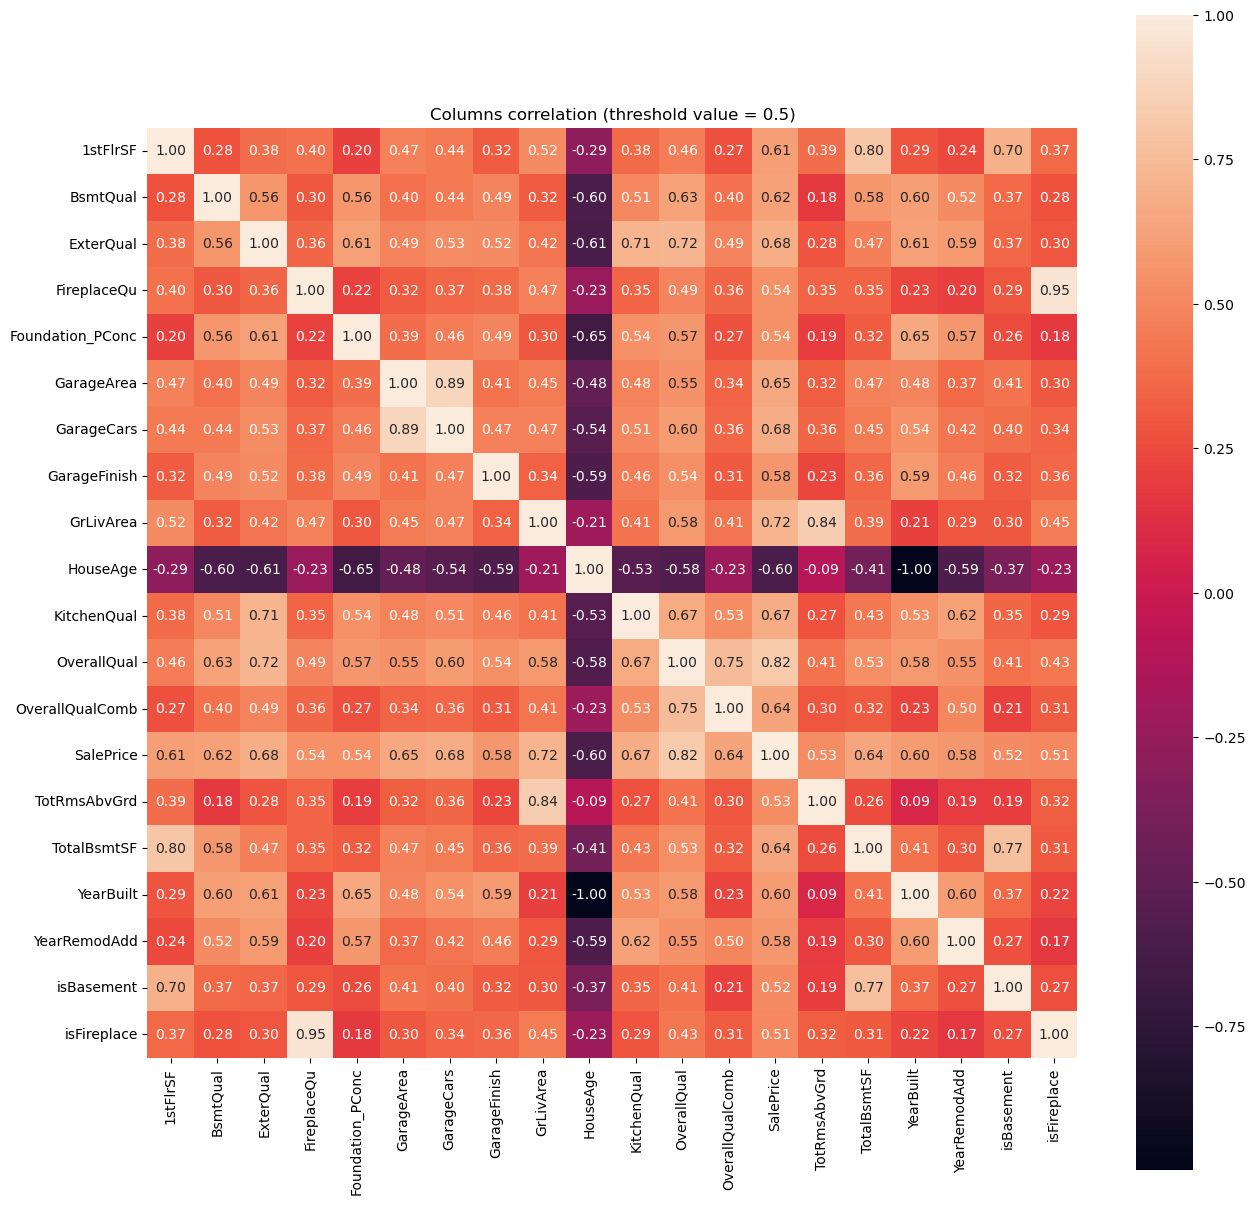

In [16]:
# Calculate the correlation matrix for the training dataset
# The numeric_only=True parameter ensures that only numeric columns are included in the correlation computation
correlations = train.corr(numeric_only=True)

# Set a threshold value for filtering correlations
# This threshold will help us focus on features with a strong correlation (>= 0.5 or <= -0.5) with 'SalePrice'
threshold_value = 0.5 

# Select features that have an absolute correlation with 'SalePrice' greater than or equal to the threshold
# This filters the correlation DataFrame to retain only those columns with significant correlation
threshold_params = correlations[abs(correlations["SalePrice"]) >= threshold_value]

# Get the index values of the filtered parameters as a list
# This helps in referencing the relevant features for visualization
threshold_indexes = threshold_params.index.values.tolist()

# Refine the threshold_params DataFrame to keep only the relevant correlations
threshold_params = threshold_params[threshold_indexes]

# Create a heatmap to visualize the correlation matrix of the filtered parameters
plt.figure(figsize=(15, 15))  # Set the figure size for better visibility
sns.heatmap(threshold_params, square=True, annot=True, fmt=".2f")  # Create the heatmap with annotations
plt.title(f'Columns correlation (threshold value = {threshold_value})')  # Set the title of the plot

### Features to consider: 1stFlrSF / TotalBsmtSF, isFireplace / FireplaceQu, GarageCars / GarageArea, YearBuilt / HouseAge, GrLivArea / TotRmsAbvGrd

In [17]:
# Automated Feature Selection using SelectKBest
selector = SelectKBest(score_func=f_regression, k=20)  # Select top 20 features
train_new = selector.fit_transform(train, train['SalePrice'])
selected_features = train.columns[selector.get_support()]
print(selected_features)

Index(['1stFlrSF', 'BsmtQual', 'ExterQual', 'FireplaceQu', 'Foundation_PConc',
       'GarageArea', 'GarageCars', 'GarageFinish', 'GrLivArea', 'HeatingQC',
       'HouseAge', 'KitchenQual', 'OverallQual', 'OverallQualComb',
       'TotRmsAbvGrd', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd',
       'isBasement', 'isFireplace'],
      dtype='object')


### Therefore:
### - 'GarageArea' goes first, then drop 'GarageCars'
### - '1stFlrSF' goes first, then drop 'TotalBsmtSF'
### - 'HouseAge' goes first, then drop 'YearBuilt'
### - 'GrLivArea' goes first, then drop 'TotRmsAbvGrd'

In [18]:
train.drop(['GarageCars', 'TotalBsmtSF', 'YearBuilt', 'TotRmsAbvGrd'], axis=1, inplace=True)
test.drop(['GarageCars', 'TotalBsmtSF', 'YearBuilt', 'TotRmsAbvGrd'], axis=1, inplace=True)

# 6. The main function and Modeling Approach

In [19]:
dirname = '/kaggle/input/house-prices-advanced-regression-techniques/'
# using os.path.join to ensure that the code works correctly on different operating systems.
# they have different conventions for representing file paths.
train = pd.read_csv(os.path.join(dirname, "train.csv"), index_col = "Id") # index_col to specify which column should be used as the row labels (index) for the DataFrame
test = pd.read_csv(os.path.join(dirname, "test.csv"), index_col = "Id")

# Define the features to be scaled
continuous_features = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                      '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
                      'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']

# Handle outliers and missing values
train = handle_outliers_moderate(train)
train, test = deal_with_missing_values(train, test)
train['SalePrice'] = np.log1p(train['SalePrice'])

# Initialize the scaler
scaler = StandardScaler()

# Scale only the continuous features
train_scaled = scaler.fit_transform(train[continuous_features])
test_scaled = scaler.transform(test[continuous_features])

# Convert scaled arrays back to DataFrames with the original column names
train_scaled_df = pd.DataFrame(train_scaled, columns=continuous_features, index=train.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=continuous_features, index=test.index)

# Concatenate the scaled features with the other (non-scaled) features
train_non_scaled = train.drop(columns=continuous_features)
test_non_scaled = test.drop(columns=continuous_features)

train = pd.concat([train_scaled_df, train_non_scaled], axis=1)
test = pd.concat([test_scaled_df, test_non_scaled], axis=1)

# parameters were tuned separately
train, test = apply_feature_engineering(train, test, addisFence=False, addisFireplace=False, apply_add_HouseAge=True, apply_add_isRemodelled=False, 
                                        apply_add_RemodelledYearsAgo=True, apply_add_BsmtFinSF_remove_SF1_SF2=False, addisMasonry=False, 
                                        addisSecondFloor=False, addisFullBathBsmtDropBsmtHalfBath=False, addisBsmtHalfBathDropBsmtHalfBath=False, 
                                        addisFullBathDropFullBath=True, addisHalfBathDropHalfBath=False, addisFireplaceDropFireplaces=True, 
                                        addisWoodDeck=False, addisOpenPorch=False, addisGarage=False, addisBasement=True, addTotalBsmtSFComb=True, 
                                        addOverallQualComb=True)

train, test = handle_categoricals(train, test)

train.drop(['GarageCars', 'TotalBsmtSF', 'YearBuilt', 'TotRmsAbvGrd'], axis=1, inplace=True)
test.drop(['GarageCars', 'TotalBsmtSF', 'YearBuilt', 'TotRmsAbvGrd'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(train.drop('SalePrice', axis=1), train['SalePrice'], test_size=0.1, random_state=42)

Removed 20 outliers
Handling nulls is done. Check for nulls...
Does train have nulls? True
Does test have nulls? True
Train shape: (1440, 257)
Test shape: (1459, 256)
Are train and test columns equal? True


## a. First model to try: Random Forest
### Increasing or decreasing depth didn't help. Increasing the amount of estimators significantly impacts waiting time, but poorly affect the result. The model also has worse accuracy compared to other algorithms, so it had been left behind.

In [ ]:
# Initialize the Random Forest Regressor model with specific parameters
# n_estimators: number of trees in the forest (300 trees)
# random_state: seed for random number generator to ensure reproducibility (42)
# max_depth: maximum depth of each tree (90)
model_rf = RandomForestRegressor(n_estimators=300, random_state=42, max_depth=90)

# Evaluate the model using cross-validation
# cv: number of folds for cross-validation (10)
# scoring: performance metric to evaluate the model ('neg_mean_squared_error' for negative MSE)
cv_scores = cross_val_score(model_rf, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Convert negative MSE scores to positive values
cv_mse = -cv_scores 

# Calculate the RMSE (Root Mean Squared Error) from the cross-validated MSE scores
cv_rmse = np.sqrt(np.mean(cv_mse))

# Print the mean cross-validated RMSE
print("Mean cross-val   RMSE:", cv_rmse)

In [ ]:
# Fit the Random Forest model on the training data
model_rf.fit(X_train, y_train)

# Make predictions on the test data using the fitted model
test_predictions_rf = model_rf.predict(X_test)

# Calculate and print the RMSE (Root Mean Squared Error) of the predictions compared to the actual test labels
# mean_squared_error: computes the mean squared error between true and predicted values
print(f"Random Forest accuracy on test: {np.sqrt(mean_squared_error(y_test, test_predictions_rf))}")

## b. Second model: AdaBoost
### It was the slowest one and also showed the worst results. Increasing depth leads to a drastic time consuming; left behind due to the time and accuracy issues.

In [ ]:
# Define the base estimator for AdaBoost as a Random Forest Regressor with a maximum depth of 7
base_estimator = RandomForestRegressor(max_depth=7)

# Create the AdaBoost Regressor using the defined base estimator, with 200 estimators and a fixed random state for reproducibility
model_ada = AdaBoostRegressor(estimator=base_estimator, n_estimators=200, random_state=42)

# Perform cross-validation on the training data using 10 folds
# Use negative mean squared error as the scoring method; it returns negative values which we will convert back to positive
cv_scores = cross_val_score(model_ada, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Convert negative MSE scores to positive values
cv_mse = -cv_scores

# Calculate the root mean squared error (RMSE) from the cross-validated MSE scores
cv_rmse = np.sqrt(np.mean(cv_mse))

# Print the mean cross-validated RMSE for the AdaBoost model
print("Mean cross-val RMSE for AdaBoost:", cv_rmse)

In [ ]:
# Fit the AdaBoost model on the training data (X_train and y_train)
model_ada.fit(X_train, y_train)

# Generate predictions on the test data (X_test) using the trained AdaBoost model
test_predictions_ada = model_ada.predict(X_test)

# Calculate the root mean squared error (RMSE) by comparing the true values (y_test) and the predicted values
# Print the RMSE as a measure of model accuracy on the test set
print(f"AdaBoost accuracy on test: {np.sqrt(mean_squared_error(y_test, test_predictions_ada))}")

## c. Third model: LGBM
### The model showed an extremely good performance both time and accuracy.

In [21]:
# Define the parameters for the LightGBM regression model
params = {
    'objective': 'regression',  # Specify the type of task (regression in this case)
    'boosting_type': 'gbdt',    # Specify the boosting type (Gradient Boosting Decision Tree)
    'num_leaves': 4,            # Set the maximum number of leaves per tree
    'learning_rate': 0.08,       # Set the learning rate for weight updates
    'n_estimators': 4300,        # Set the number of boosting iterations (trees to be built) 4300
    'random_state': 42           # Set a random seed for reproducibility
}

# Initialize the LightGBM regressor with the defined parameters
model_lgbm = lgb.LGBMRegressor(**params)

# Perform 10-fold cross-validation to evaluate the model
cv_scores = cross_val_score(model_lgbm, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Convert negative mean squared error scores to positive values
cv_mse = -cv_scores

# Calculate the root mean squared error (RMSE) from the mean squared errors
cv_rmse = np.sqrt(np.mean(cv_mse))

# Print the mean RMSE from cross-validation as a measure of model performance
print("Mean cross-val RMSE for LightGBM:", cv_rmse)

Mean cross-val RMSE for LightGBM: 0.12080299248543029


In [22]:
# Fit the LightGBM model on the training data
model_lgbm.fit(X_train, y_train)

# Use the trained model to make predictions on the test data
test_predictions_lgbm = model_lgbm.predict(X_test)

# Calculate the Root Mean Squared Error (RMSE) to evaluate the model's performance on the test set
# Compare the actual target values (y_test) with the predicted values (test_predictions_lgbm)
rmse = np.sqrt(mean_squared_error(y_test, test_predictions_lgbm))

# Print the RMSE as a measure of the model's accuracy on the test data
print(f"LGBMRegressor accuracy on test: {rmse}")

LGBMRegressor accuracy on test: 0.10844841882177146


## d. The fourth model: XGBoost
### Not the slowest model and also has a good performance, almost equally as good as LGBM

In [23]:
# Define parameters for the XGBoost regressor
params = {
    'objective': 'reg:squarederror',  # Specify the objective function for regression
    'booster': 'gbtree',               # Use the tree-based booster
    'learning_rate': 0.09,             # Set the learning rate (step size) for the optimization
    'n_estimators': 700,               # Number of boosting rounds (trees) to train
    'random_state': 42                 # Seed for reproducibility
}

# Initialize the XGBoost regressor with the specified parameters
model_xgb = xgb.XGBRegressor(**params)

# Perform cross-validation to evaluate the model's performance
# Use 10-fold cross-validation and compute the negative mean squared error as the scoring metric
cv_scores = cross_val_score(model_xgb, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Convert negative mean squared error to positive values for interpretation
cv_mse = -cv_scores

# Calculate the root mean squared error (RMSE) from the mean squared error scores
cv_rmse = np.sqrt(np.mean(cv_mse))

# Print the mean cross-validated RMSE for the XGBoost model
print("Mean cross-val RMSE for XGBoost: ", cv_rmse)

Mean cross-val RMSE for XGBoost:  0.12180840540433518


In [24]:
# Fit the XGBoost model on the training data
model_xgb.fit(X_train, y_train)

# Use the trained model to make predictions on the test dataset
test_predictions_xgb = model_xgb.predict(X_test)

# Calculate and print the root mean squared error (RMSE) for the model's predictions on the test set
# This indicates the accuracy of the model on unseen data
print(f"XGBRegressor accuracy on test: {np.sqrt(mean_squared_error(y_test, test_predictions_xgb))}")

XGBRegressor accuracy on test: 0.1201610555767347


# 7. Ensembling
### Combining two the most efficient models to increase the score. Performed successfully.

In [25]:
# Create a list of estimators to combine in the ensemble model
# Here, we include LightGBM and XGBoost models
estimators = [("LGBM", model_lgbm), ("XGB", model_xgb)] 

# Initialize the Voting Regressor, which combines the predictions of multiple models
ensemble = VotingRegressor(estimators) 

# Train the ensemble model on the training data (features and target values)
ensemble.fit(X_train, y_train)

# Use the trained ensemble model to make predictions on the test dataset
ensemble_predictions = ensemble.predict(X_test)

# Evaluate the ensemble's performance using root mean squared error (RMSE)
# This measures the accuracy of the model's predictions against the actual target values
ensemble_rmse = np.sqrt(mean_squared_error(ensemble_predictions, y_test))

# Print the RMSE of the ensemble model, indicating its performance
print("Voting Ensemble RMSE:", ensemble_rmse)

Voting Ensemble RMSE: 0.1114381539320571


# 8. Conclusion
### The best model is LGBM. The closest to it is XGBoost. Their combination has given the final and the lowest error of **0.1067091228088019**.

# 9. Submission

In [26]:
# Train the ensemble model on the training data (features and target values)
ensemble.fit(X_train, y_train)

# Use the trained ensemble model to make predictions on the test dataset
# Here, 'test' is expected to be a DataFrame containing the features of the test set
test_predictions_ens = ensemble.predict(test)

In [27]:
# Revert the log transformation applied to the predicted prices
# The np.expm1 function is used to reverse the log1p transformation
predicted_prices = np.expm1(test_predictions_ens)

# Create a DataFrame to hold the submission data with 'Id' and 'SalePrice' columns
# 'Id' is taken from the index of the test DataFrame, and 'SalePrice' contains the reverted predictions
submission_df = pd.DataFrame({'Id': test.index, 'SalePrice': predicted_prices})

# Save the submission DataFrame to a CSV file named 'submission.csv'
filename = 'submission.csv'
submission_df.to_csv(filename, index=False)

# Print a confirmation message indicating that the submission file has been created
print(f"Submission file created: {filename}")

Submission file created: submission.csv


In [28]:
import joblib

joblib.dump(ensemble, 'best_ensemble_xgboost_lgbm_model.joblib')

['best_ensemble_xgboost_lgbm_model.joblib']